In [1]:
import os 
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.stats.diagnostic import acorr_ljungbox
sns.set(rc={'figure.figsize':(15,6)})

Step-1: Loading Data

In [3]:
os.getcwd() 
os.chdir('C:/Users/eduar/OneDrive/Escritorio/Masterado/Primer Semestre/Time Series Analysis/Project/AirTemp')
df = pd.read_excel('stockholm_daily_mean_temperature2.xlsx')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97495 entries, 0 to 97494
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    97495 non-null  object 
 1   raw     97495 non-null  float64
 2   homo    97495 non-null  float64
 3   adjust  97495 non-null  float64
 4   site    97495 non-null  int64  
dtypes: float64(3), int64(1), object(1)
memory usage: 3.7+ MB
None


Step-2: Data Cleansing

In [4]:
df = df.iloc[52595:97488] ##include data from 1900's
df['date2'] = pd.to_datetime(df['date']) ##create new date
df = df[['date2','adjust']] ##select adjust and new date
df.rename(columns = {'date2':'date'}, inplace = True)##change name to a column
df.set_index('date',inplace=True) ##set the date variable to the index
df = df.resample('M').mean() ##aggregation from daily to monthly values

Step-3: Plotting Data

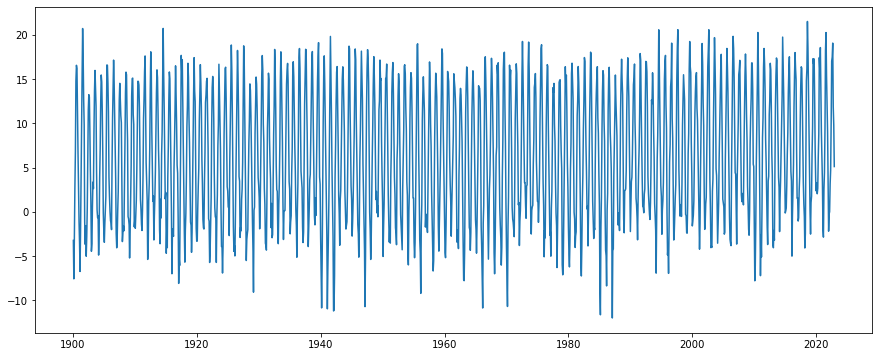

In [5]:
plt.figure(figsize=(15,6))
plt.plot(df.adjust)

Step-4:Time Series Decomposition

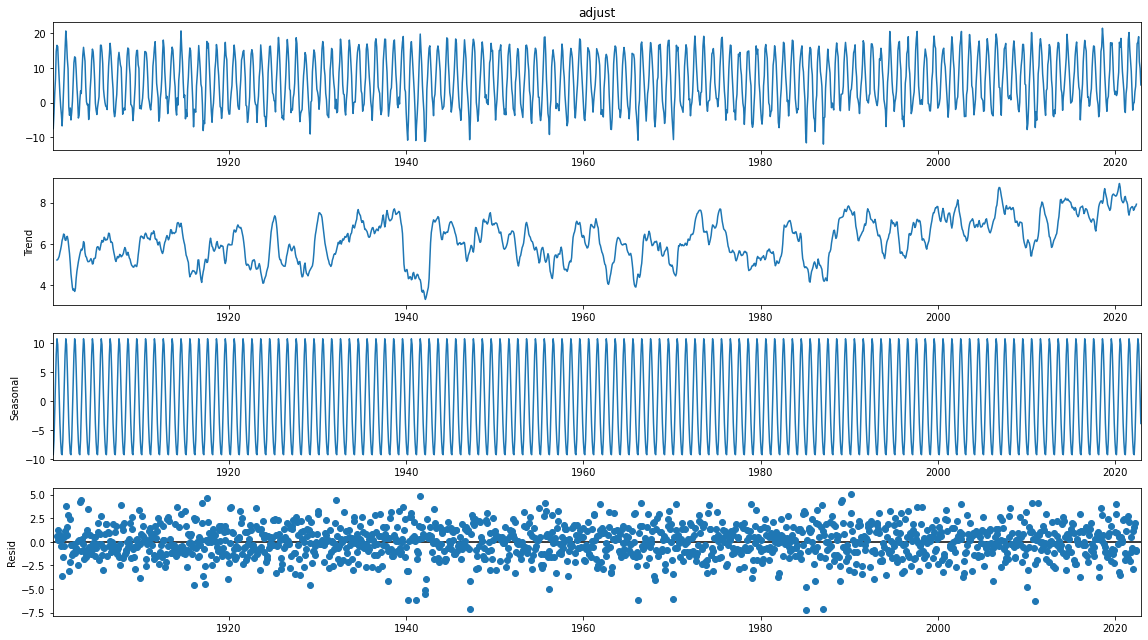

In [6]:
decomposition = sm.tsa.seasonal_decompose(df.adjust, model='additive')
plt.rcParams["figure.figsize"] = [16,9]
fig = decomposition.plot()

Step-5: Time Series Analysis

In [7]:
model = df.adjust
train = df.adjust[:'2017-11-30'].to_frame()
test = df.adjust['2017-12-31':].to_frame()

In [8]:
from statsmodels.tsa.stattools import adfuller
def check_stationarity(timeseries):    
    result = adfuller(timeseries,autolag='AIC')
    dfoutput = pd.Series(result[0:4], 
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    print('The test statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
check_stationarity(train)

The test statistic: -4.686361
p-value: 0.000089
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


C:\Users\eduar\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


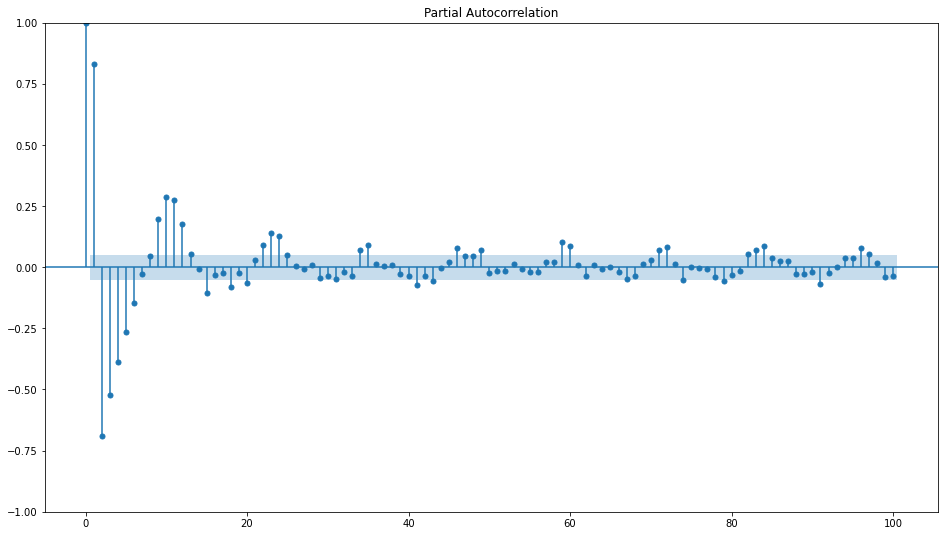

<Figure size 720x144 with 0 Axes>

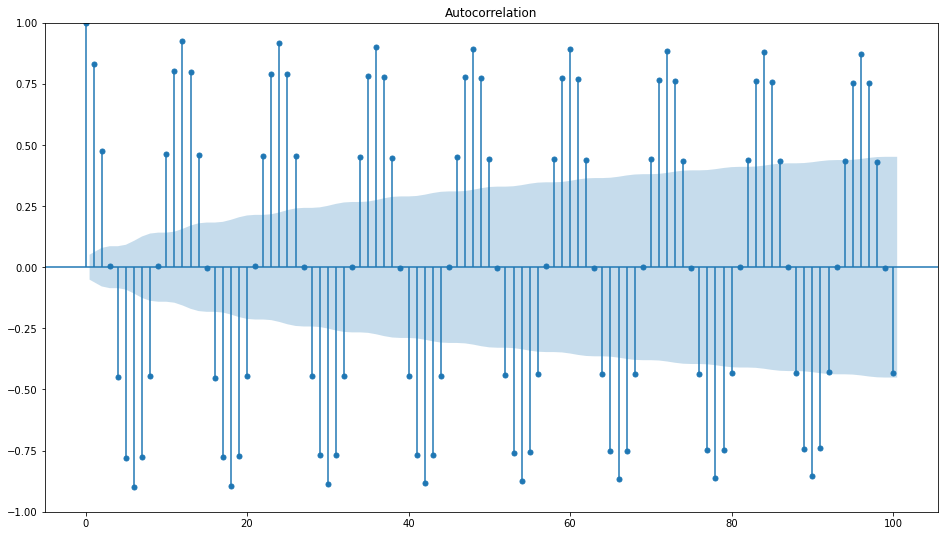

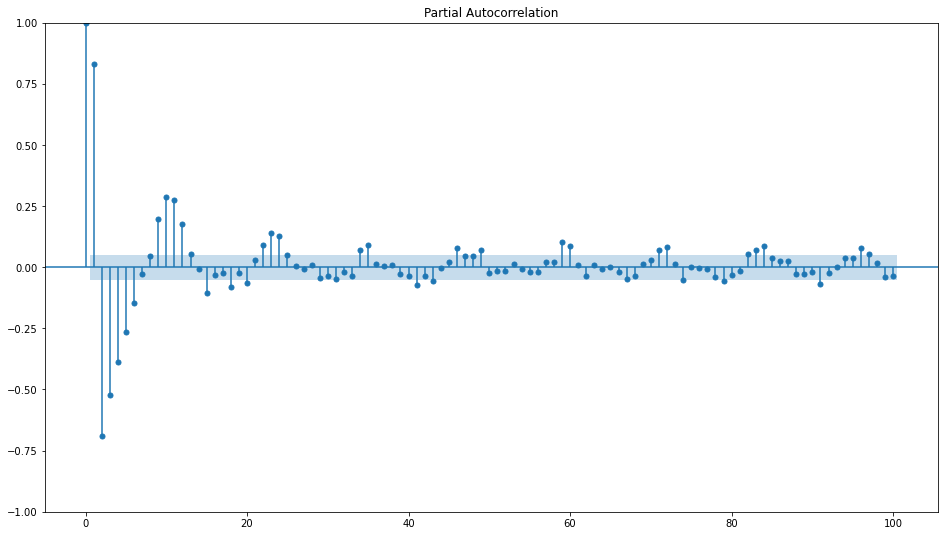

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.figure(figsize=(10,2))
plot_acf(df.adjust, lags=100) ## seasonal patterns decay exponentially
plot_pacf(df.adjust, lags=100) ## seasonal patterns end abruptly 

The test statistic: -9.802576
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


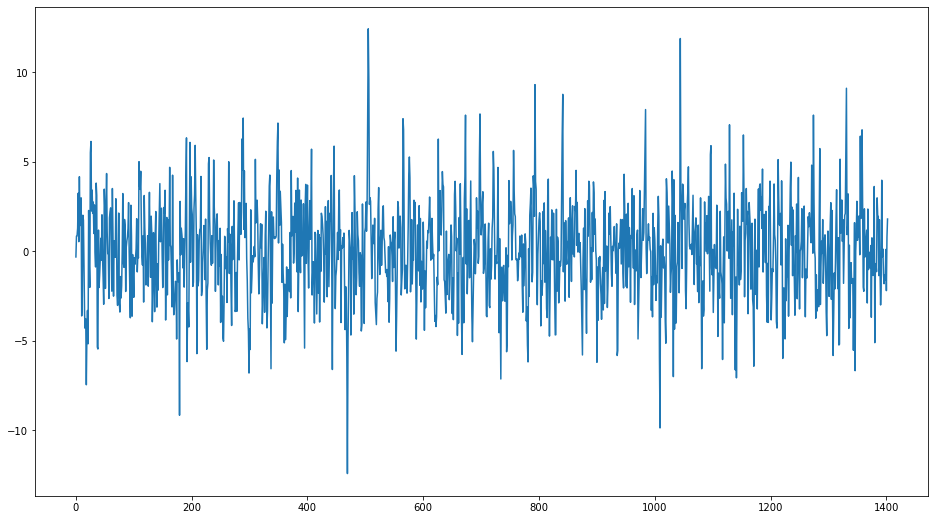

In [10]:
train['adjustdiff'] = train - train.shift(12)
df_diff12 = train['adjustdiff'].to_numpy()
df_diff12 = df_diff12[~np.isnan(df_diff12)] #drop missing data
plt.plot(df_diff12)
check_stationarity(df_diff12)


The test statistic: -13.508585
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


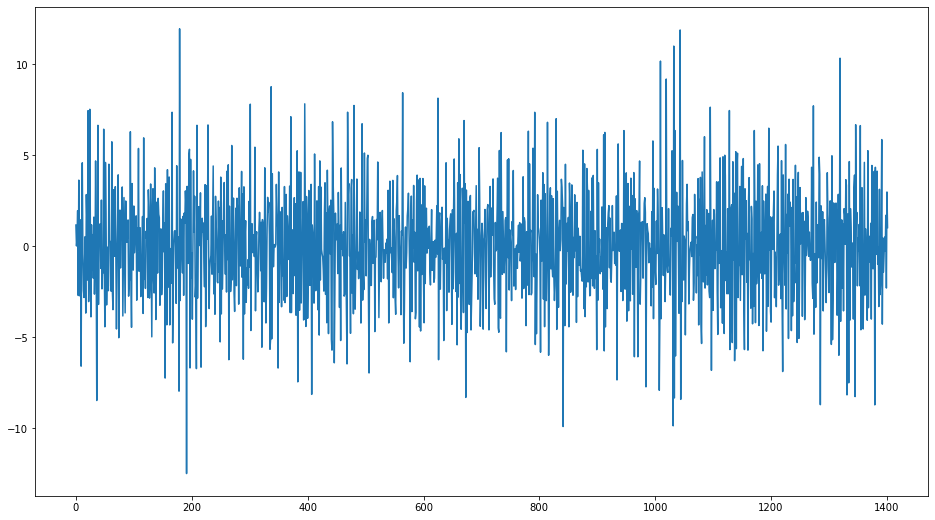

In [11]:
train['adjustdiff2'] = train['adjustdiff'] - train['adjustdiff'].shift(1)
df_diff12diff = train['adjustdiff2'].to_numpy()
df_diff12diff = df_diff12diff[~np.isnan(df_diff12diff)] #drop missing data
plt.plot(df_diff12diff)
check_stationarity(df_diff12diff)

C:\Users\eduar\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


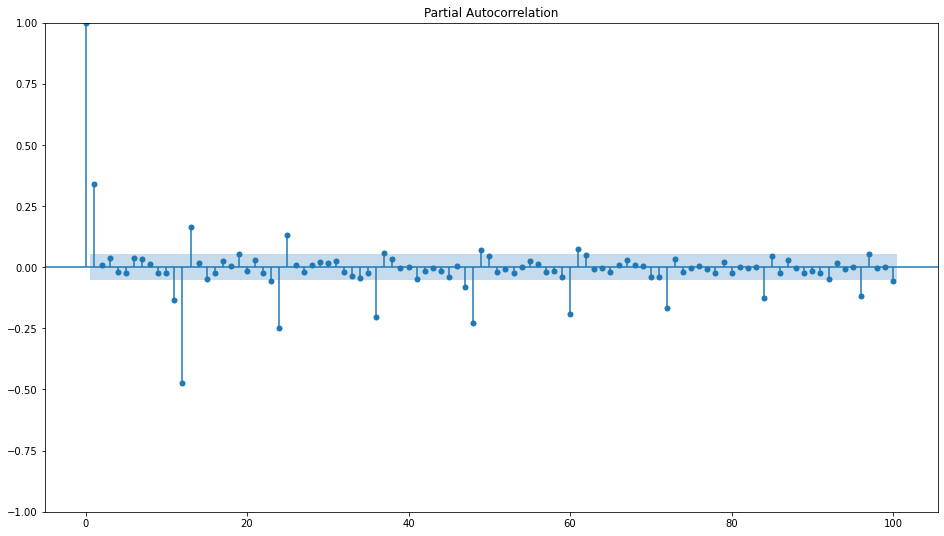

<Figure size 720x144 with 0 Axes>

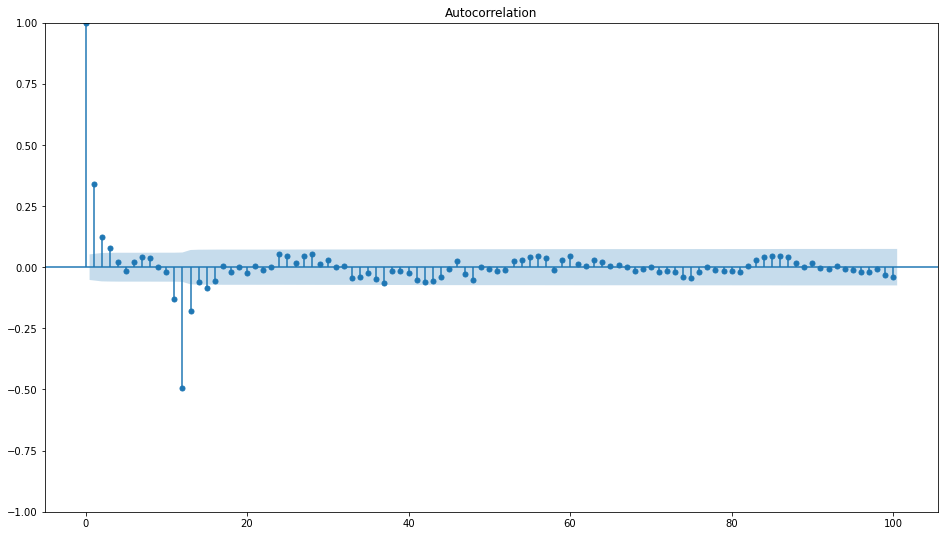

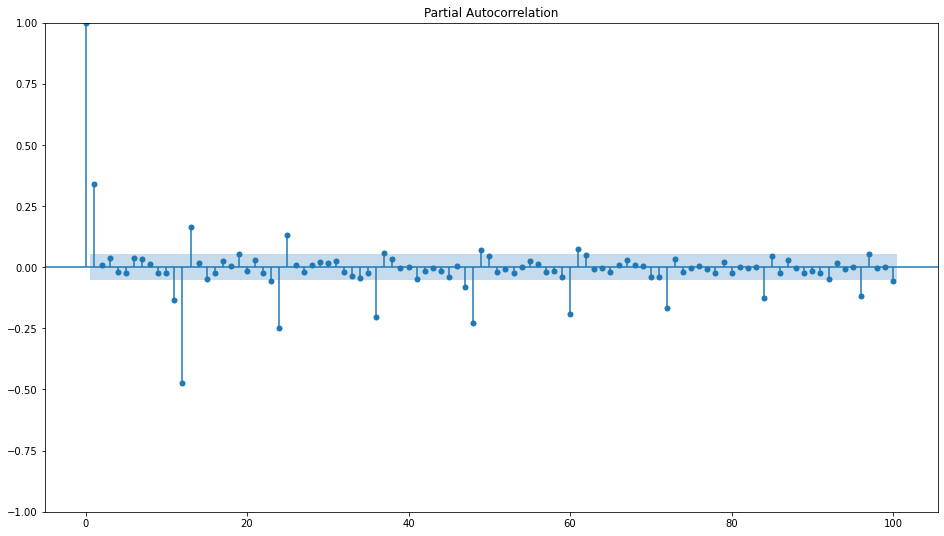

In [12]:
plt.figure(figsize=(10,2))
plot_acf(df_diff12, lags=100) ## MA = 3 and SMA = 1
plot_pacf(df_diff12, lags=100) ## AR = 1 and NO SAR

C:\Users\eduar\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


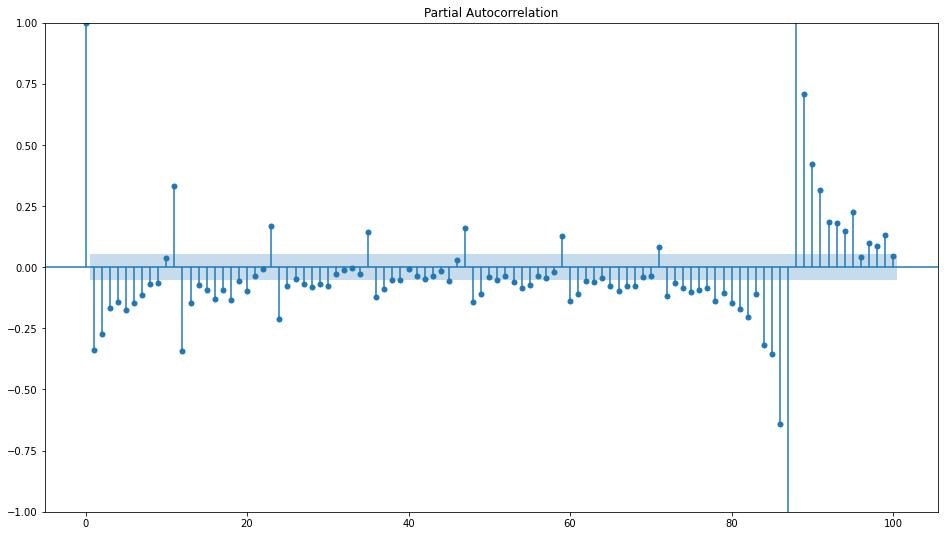

<Figure size 720x144 with 0 Axes>

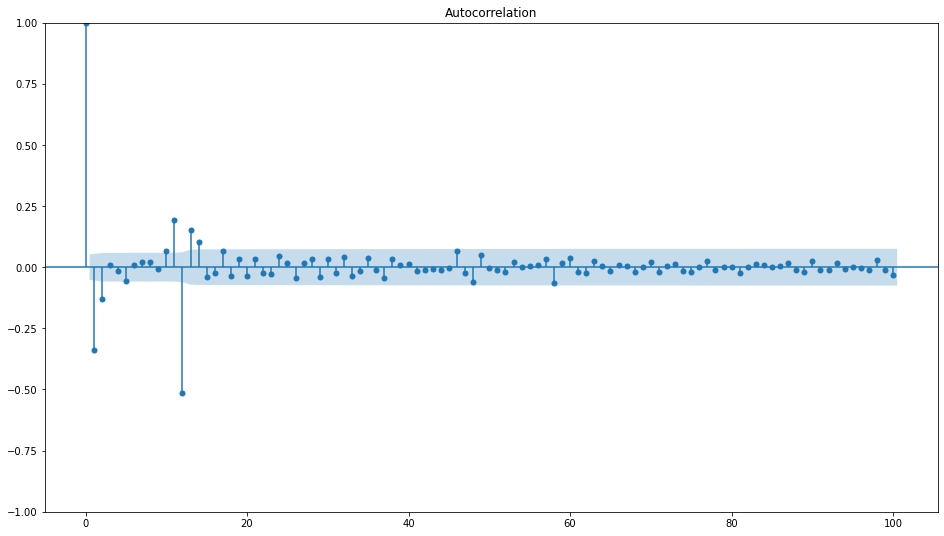

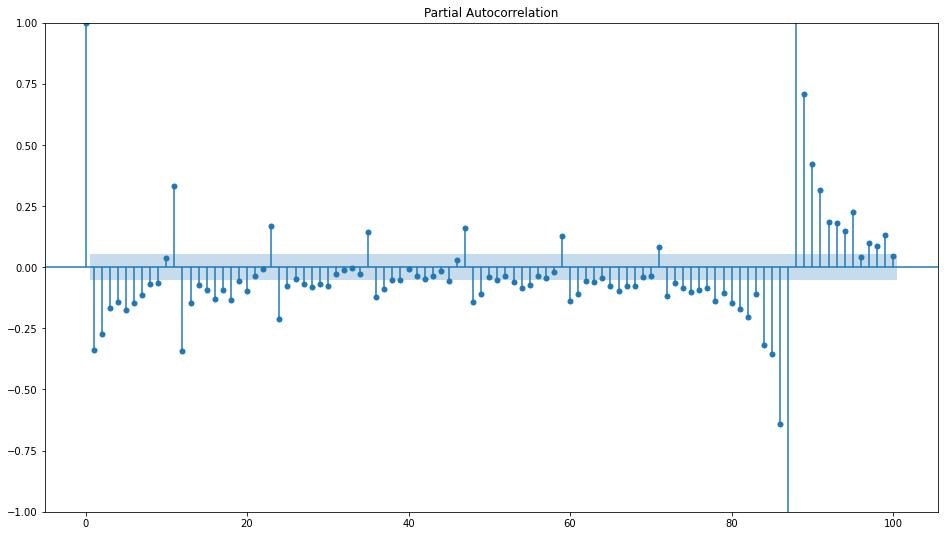

In [13]:
plt.figure(figsize=(10,2))
plot_acf(df_diff12diff, lags=100) 
plot_pacf(df_diff12diff, lags=100)

Step-6: Time Series Models

In [14]:
# Fit a SARIMA(1,0,3)(0,1,1)12 model
model1 = sm.tsa.statespace.SARIMAX(train.adjust, 
                                order=(1,0,3), 
                                seasonal_order=(0,1,1,12)
                                )
results1 = model1.fit()
print(results1.summary())

                                      SARIMAX Results                                       
Dep. Variable:                               adjust   No. Observations:                 1415
Model:             SARIMAX(1, 0, 3)x(0, 1, [1], 12)   Log Likelihood               -2865.995
Date:                              Tue, 18 Apr 2023   AIC                           5743.989
Time:                                      19:04:16   BIC                           5775.467
Sample:                                  01-31-1900   HQIC                          5755.755
                                       - 11-30-2017                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9602      0.023     42.448      0.000       0.916       1.005
ma.L1         -0.59

C:\Users\eduar\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


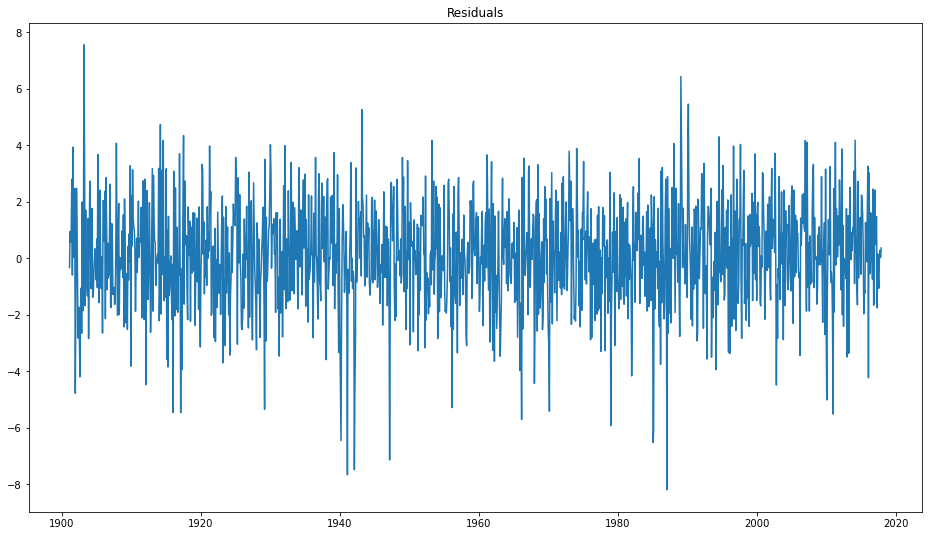

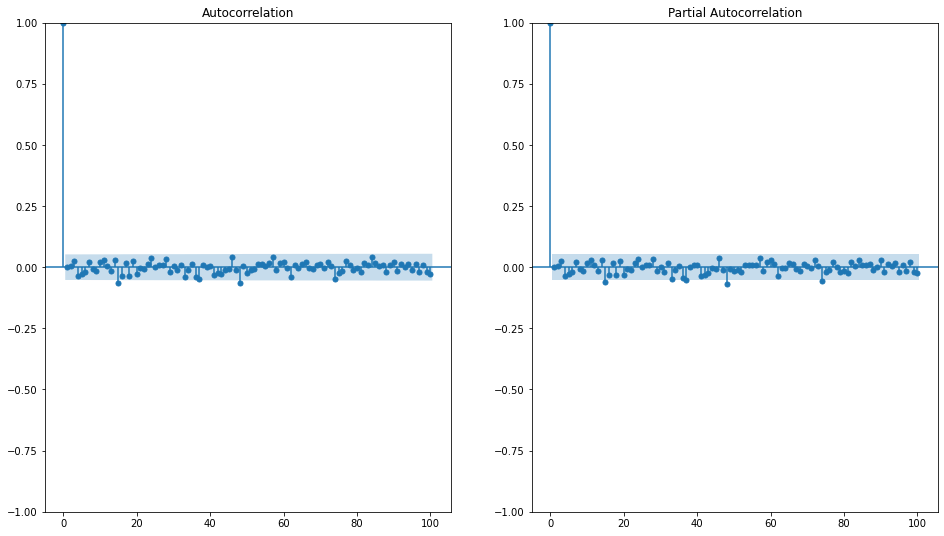

,lb_stat,lb_pvalue
24,22.981977,0.520862


In [15]:
# Plot residual errors
resid1 = pd.DataFrame(results1.resid)[12:]
fig, axes = plt.subplots()  
axes.plot(resid1)
axes.set_title("Residuals")
fig, axes = plt.subplots(1, 2, sharex=True)
plot_acf(resid1.dropna(), lags=100, ax=axes[0])
plot_pacf(resid1.dropna(), lags=100, ax=axes[1])
plt.show()
acorr_ljungbox(resid1, lags=[24], return_df=True)

                                      SARIMAX Results                                       
Dep. Variable:                               adjust   No. Observations:                 1415
Model:             SARIMAX(1, 0, 2)x(0, 1, [1], 12)   Log Likelihood               -2870.876
Date:                              Tue, 18 Apr 2023   AIC                           5751.753
Time:                                      19:05:07   BIC                           5777.985
Sample:                                  01-31-1900   HQIC                          5761.558
                                       - 11-30-2017                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9039      0.036     25.224      0.000       0.834       0.974
ma.L1         -0.55

C:\Users\eduar\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


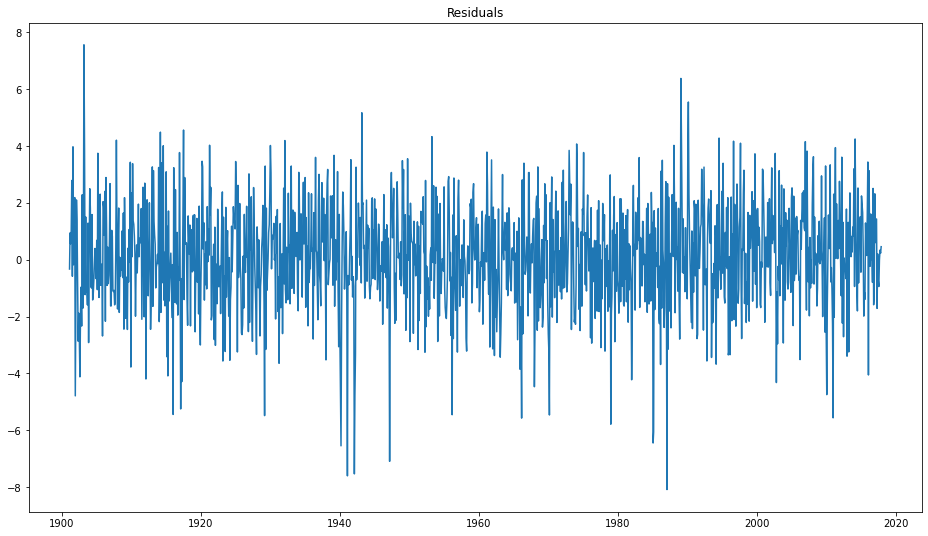

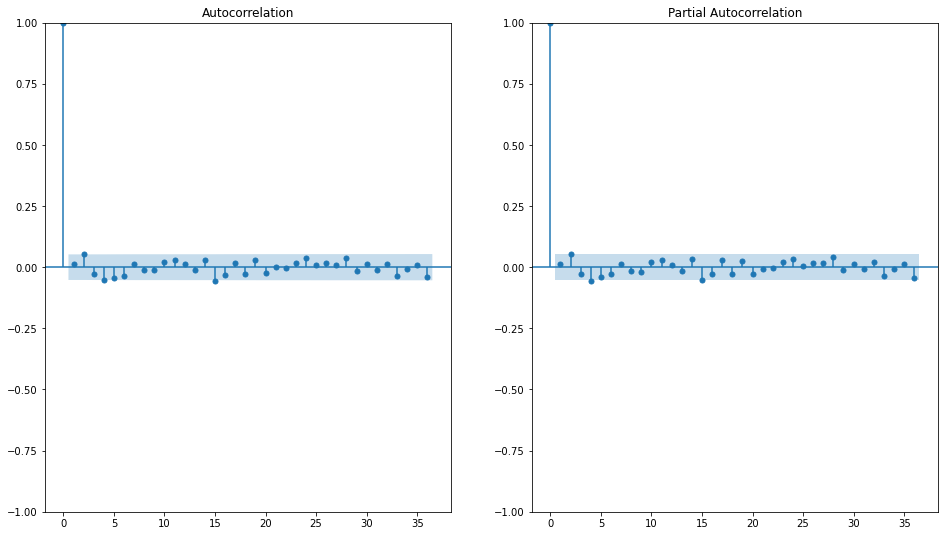

,lb_stat,lb_pvalue
24,30.80934,0.159356


In [16]:
# Fit a SARIMA(1,0,2)(0,0,1)12 model
model2 = sm.tsa.statespace.SARIMAX(train.adjust, 
                                order=(1,0,2), 
                                seasonal_order=(0,1,1,12)
                                )
results2 = model2.fit()
print(results2.summary())
# Plot residual errors
resid2 = pd.DataFrame(results2.resid)[12:]
fig, axes = plt.subplots()  
axes.plot(resid2)
axes.set_title("Residuals")
fig, axes = plt.subplots(1, 2, sharex=True)
plot_acf(resid2, lags=36, ax=axes[0])
plot_pacf(resid2, lags=36, ax=axes[1])
plt.show()
acorr_ljungbox(resid2, lags=[24], return_df=True)

                                     SARIMAX Results                                      
Dep. Variable:                             adjust   No. Observations:                 1415
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood               -2871.692
Date:                            Tue, 18 Apr 2023   AIC                           5751.384
Time:                                    19:05:17   BIC                           5772.370
Sample:                                01-31-1900   HQIC                          5759.228
                                     - 11-30-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5053      0.057      8.917      0.000       0.394       0.616
ma.L1         -0.1364      0.063   

C:\Users\eduar\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


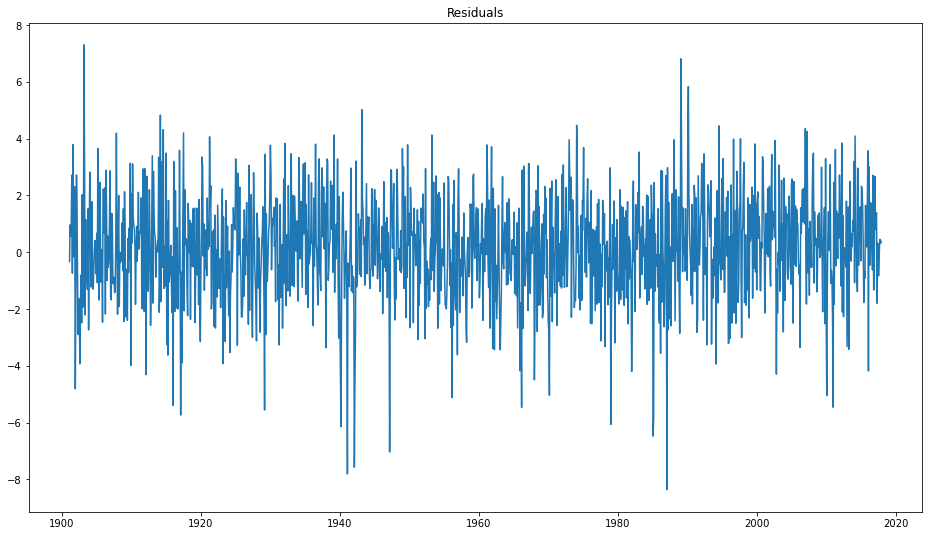

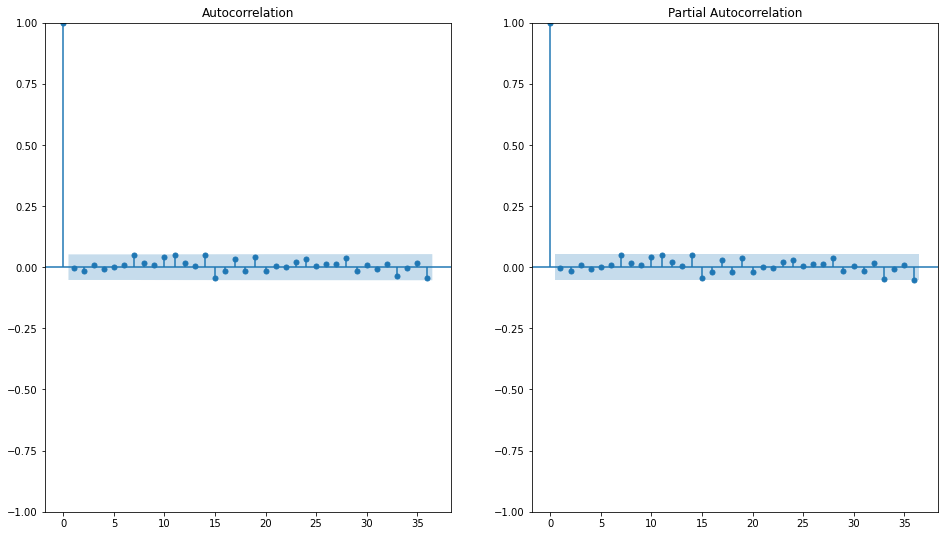

,lb_stat,lb_pvalue
1,0.021624,0.883092


In [17]:
# Fit a SARIMA(1,0,1)(0,0,1)12 model
model3 = sm.tsa.statespace.SARIMAX(train.adjust, 
                                order=(1,0,1), 
                                seasonal_order=(0,1,1,12)
                                )
results3 = model3.fit()
print(results3.summary())
# Plot residual errors
resid3 = pd.DataFrame(results3.resid)[12:]
fig, axes = plt.subplots()  
axes.plot(resid3)
axes.set_title("Residuals")

fig, axes = plt.subplots(1, 2, sharex=True)
plot_acf(resid3.dropna(), lags=36, ax=axes[0])
plot_pacf(resid3.dropna(), lags=36, ax=axes[1])
plt.show()
acorr_ljungbox(resid3, lags=[1], return_df=True)


2017-12-31    -0.076734
2018-01-31    -2.092878
2018-02-28    -2.316661
2018-03-31     0.294054
2018-04-30     4.889490
2018-05-31    10.187414
2018-06-30    14.945333
2018-07-31    17.741496
2018-08-31    16.729250
2018-09-30    12.700665
2018-10-31     7.848466
2018-11-30     3.134168
2018-12-31    -0.058527
2019-01-31    -2.074672
2019-02-28    -2.298455
2019-03-31     0.312260
2019-04-30     4.907696
2019-05-31    10.205621
2019-06-30    14.963539
2019-07-31    17.759702
2019-08-31    16.747456
2019-09-30    12.718871
2019-10-31     7.866673
2019-11-30     3.152374
2019-12-31    -0.040321
2020-01-31    -2.056465
2020-02-29    -2.280248
2020-03-31     0.330467
2020-04-30     4.925903
2020-05-31    10.223827
2020-06-30    14.981746
2020-07-31    17.777909
2020-08-31    16.765663
2020-09-30    12.737078
2020-10-31     7.884879
2020-11-30     3.170581
2020-12-31    -0.022114
2021-01-31    -2.038259
2021-02-28    -2.262042
2021-03-31     0.348673
2021-04-30     4.944109
2021-05-31    10

<AxesSubplot:xlabel='date'>

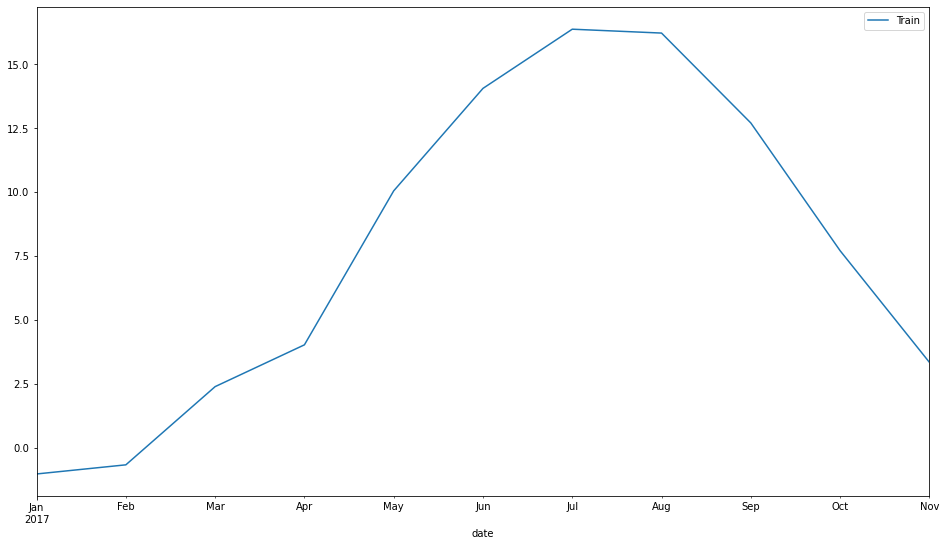

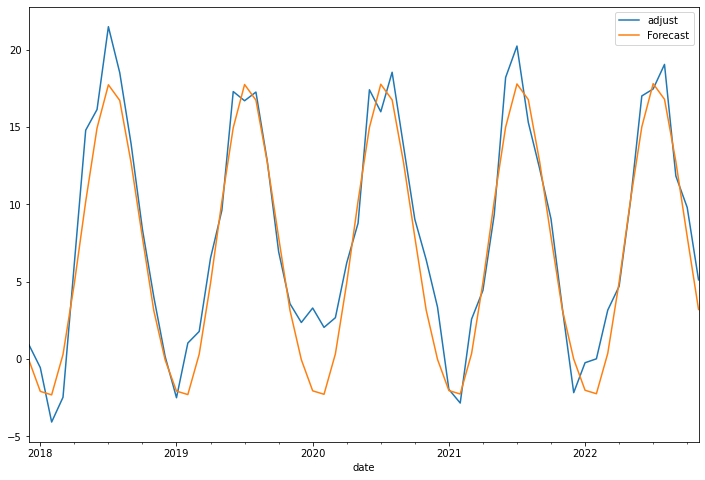

In [18]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
hw = ExponentialSmoothing(train.adjust,
                            trend='add',
                            seasonal='add',
                            seasonal_periods=12).fit()
hw_predictions = hw.forecast(60).rename('Holt Forecast')
print(hw_predictions)

train.adjust['2017-1-31':].plot(legend=True,label='Train')
test.plot(legend=True,label='Test',figsize=(12,8))
hw_predictions.plot(legend=True,label='Forecast')

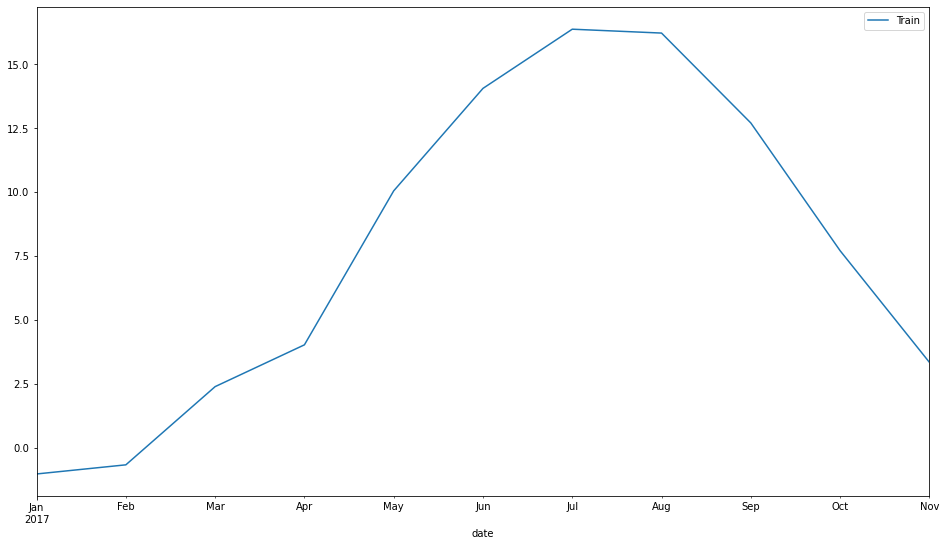

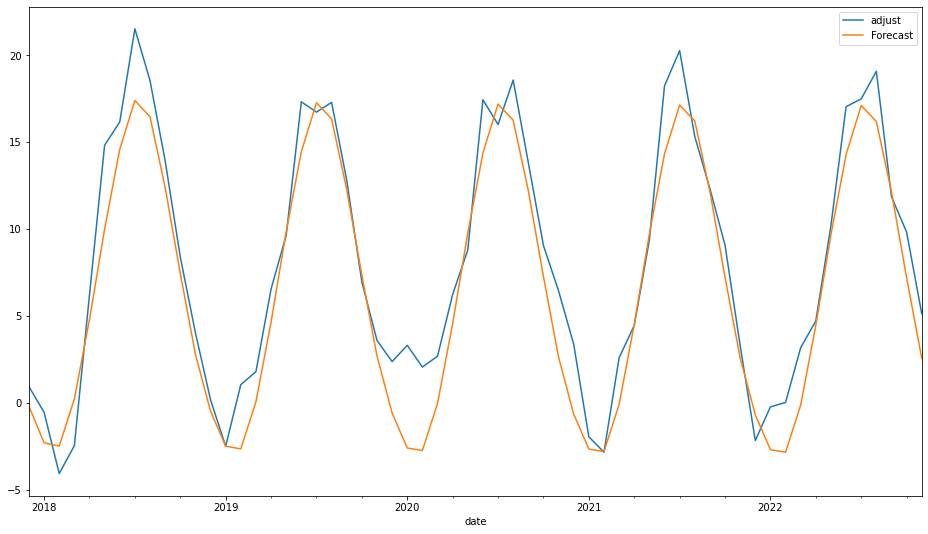

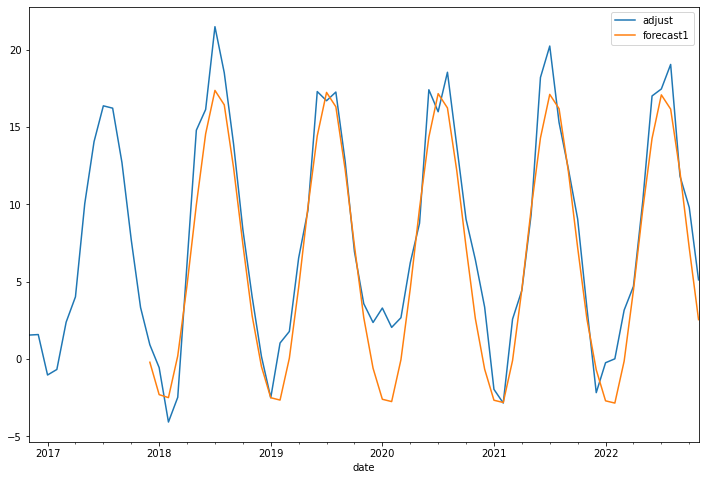

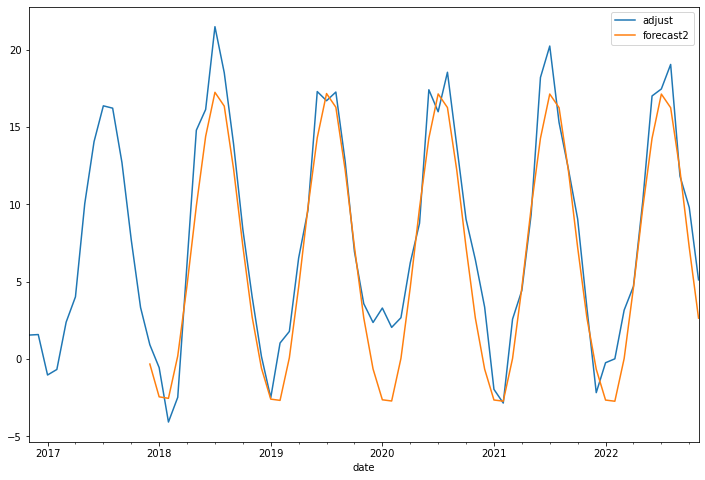

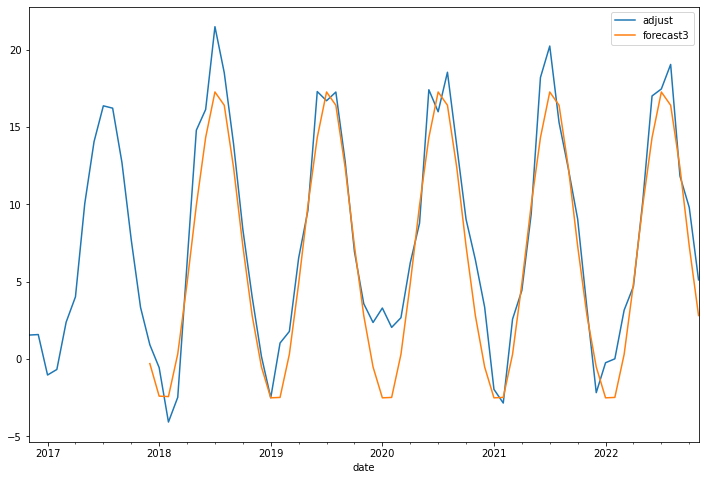

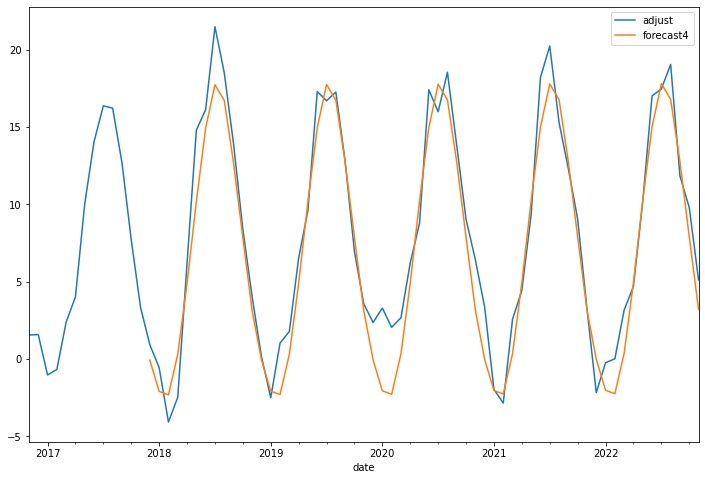

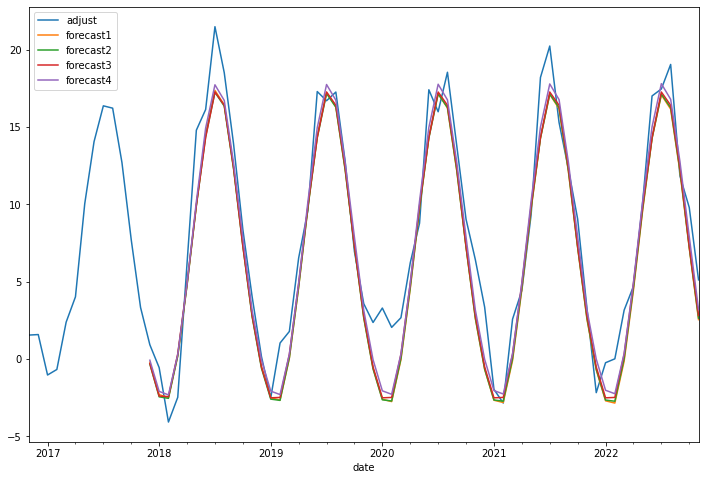

In [19]:
# Step 8) Predict the last 60 observations using all 4 models

df['forecast1'] = results1.predict(start='2017-12-31', end='2022-11-30', dynamic= True) 
df['forecast2'] = results2.predict(start='2017-12-31', end='2022-11-30', dynamic= True) 
df['forecast3'] = results3.predict(start='2017-12-31', end='2022-11-30', dynamic= True) 
df['forecast4'] = hw_predictions

train.adjust['2017-1-31':].plot(legend=True,label='Train')
test.plot(legend=True,label='Test')
results1.predict(start='2017-12-31', end='2022-11-30', dynamic= True).plot(legend=True,label='Forecast')

df[['adjust', 'forecast1']]['2016-11-30':].plot(figsize=(12, 8)) 
df[['adjust', 'forecast2']]['2016-11-30':].plot(figsize=(12, 8)) 
df[['adjust', 'forecast3']]['2016-11-30':].plot(figsize=(12, 8)) 
df[['adjust', 'forecast4']]['2016-11-30':].plot(figsize=(12, 8)) 


df[['adjust', 'forecast1','forecast2','forecast3','forecast4']]['2016-11-30':].plot(figsize=(12, 8)) 

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error 
from sklearn.metrics import mean_absolute_error


test = df.loc['2017-12-31':]

In [20]:
# Forecast Accuracy Measures


forecastmat = pd.DataFrame()  
index = ['forecast1','forecast2','forecast3','forecast4']

rmse = [round(np.sqrt(mean_squared_error(test['adjust'],test['forecast1'])),2),
        round(np.sqrt(mean_squared_error(test['adjust'],test['forecast2'])),2),
        round(np.sqrt(mean_squared_error(test['adjust'],test['forecast3'])),2),
        round(np.sqrt(mean_squared_error(test['adjust'],test['forecast4'])),2)]

mae = [round(mean_absolute_error(test['adjust'],test['forecast1']),2),
       round(mean_absolute_error(test['adjust'],test['forecast2']),2),
       round(mean_absolute_error(test['adjust'],test['forecast3']),2),
       round(mean_absolute_error(test['adjust'],test['forecast4']),2),
       ]

mape = [round(100*mean_absolute_percentage_error(test['adjust'],test['forecast1']),2),
        round(100*mean_absolute_percentage_error(test['adjust'],test['forecast2']),2),
        round(100*mean_absolute_percentage_error(test['adjust'],test['forecast3']),2),
        round(100*mean_absolute_percentage_error(test['adjust'],test['forecast4']),2)
        ]

maen = [round(mean_absolute_error(test['adjust'][1:],test['forecast1'][:-1]),2),
        round(mean_absolute_error(test['adjust'][1:],test['forecast2'][:-1]),2),
        round(mean_absolute_error(test['adjust'][1:],test['forecast3'][:-1]),2),
        round(mean_absolute_error(test['adjust'][1:],test['forecast4'][:-1]),2)
        ]

forecastmat['rmse'] = rmse
forecastmat['mae'] = mae
forecastmat['mape'] = mape
forecastmat['maen']= maen

forecastmat = forecastmat.set_index(pd.Index(index))
print(forecastmat)

           rmse   mae    mape  maen
forecast1  2.32  1.88  403.29  3.74
forecast2  2.33  1.89  390.64  3.72
forecast3  2.25  1.83  358.36  3.68
forecast4  2.03  1.65  318.93  3.70


            predictions
2022-12-31     1.034550
2023-01-31    -0.953560
2023-02-28    -1.183402
2023-03-31     1.415094
2023-04-30     5.989300
2023-05-31    11.272461
2023-06-30    16.107971
2023-07-31    18.837842
2023-08-31    17.840599
2023-09-30    13.780288
2023-10-31     8.951129
2023-11-30     4.259353
2023-12-31     1.060754
2024-01-31    -0.927356
2024-02-29    -1.157198
2024-03-31     1.441298
2024-04-30     6.015504
2024-05-31    11.298665
2024-06-30    16.134175
2024-07-31    18.864046
2024-08-31    17.866803
2024-09-30    13.806493
2024-10-31     8.977333
2024-11-30     4.285557
2024-12-31     1.086958
2025-01-31    -0.901152
2025-02-28    -1.130993
2025-03-31     1.467502
2025-04-30     6.041708
2025-05-31    11.324869
2025-06-30    16.160379
2025-07-31    18.890250
2025-08-31    17.893007
2025-09-30    13.832697
2025-10-31     9.003537
2025-11-30     4.311761
2025-12-31     1.113162
2026-01-31    -0.874948
2026-02-28    -1.104789
2026-03-31     1.493706
2026-04-30     6

C:\Users\eduar\AppData\Local\Temp\ipykernel_21652\793162247.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  forecasts2 = forecasts2.append(forecasts)


<AxesSubplot:xlabel='date'>

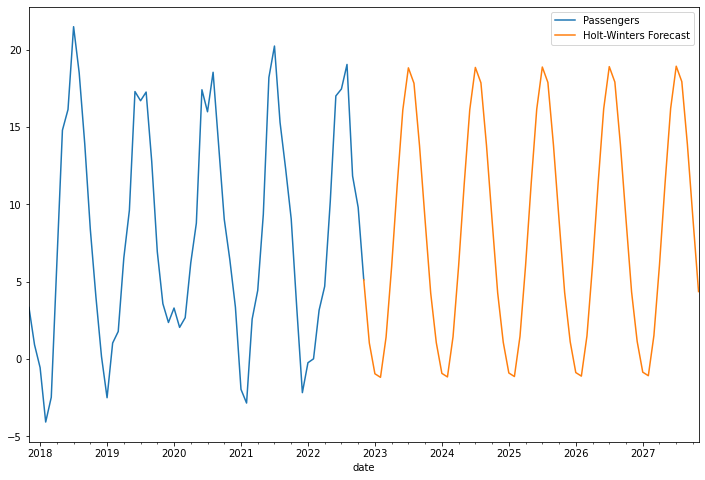

In [21]:
# Step 9) Predict the next 60 observations using the best model
hwf = ExponentialSmoothing(df['adjust'],
                               trend='add',
                               seasonal='add',
                               seasonal_periods=12).fit()
forecasts = hwf.forecast(60).rename('predictions').to_frame()
print(forecasts)


forecasts2 = pd.DataFrame({'predictions': 5.12069 },index = ['2022-11-30 00:00:00'])
forecasts2 = forecasts2.append(forecasts)
forecasts2.index = pd.to_datetime(forecasts2.index)

df['adjust']['2017-11-30':].plot(legend=True,label='Passengers',figsize=(12,8))
forecasts2['predictions'].plot(legend=True,label='Holt-Winters Forecast')

